In [1]:
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
@author: Ruiyang Zhang
"""

import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam, SGD
from keras.layers import Conv1D, Flatten, LSTM, Reshape, BatchNormalization, Activation, UpSampling1D, ZeroPadding1D, PReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # CPU:-1; GPU0: 1; GPU1: 0;

Using TensorFlow backend.


In [ ]:


class DeepPhyLSTM:
    # Initialize the class
    def __init__(self, eta_tt, ag, Phi_t):

        # data
        self.eta_tt = eta_tt
        self.ag = ag
        self.Phi_t = Phi_t

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # placeholders for data
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        self.eta_tt_tf = tf.placeholder(tf.float32, shape=[None, None, self.eta_tt.shape[2]])
        self.ag_tf = tf.placeholder(tf.float32, shape=[None, None, 1])

        # physics informed neural networks
        self.eta_pred, self.eta_t_pred, self.eta_tt_pred, = self.net_structure(self.ag_tf)

        # loss
        # for measurements
        self.loss = tf.reduce_mean(tf.square(self.eta_tt_tf - self.eta_tt_pred)) + tf.reduce_mean(tf.square(self.eta_pred[:,:,0:10]))

        # optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 20000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.train_op = self.optimizer_Adam.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)

    def CNN_model(self, X):
        model = Sequential()
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True, input_shape=(None, 1)))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Dense(50))
        model.add(Activation('relu'))
        model.add(Dense(50))
        model.add(Activation('relu'))
        model.add(Dense(self.eta_tt.shape[2]))
        y = model(X)
        return y

    def net_structure(self, ag):
        eta = self.CNN_model(ag)

        Phi_ut = np.reshape(self.Phi_t, [1, self.eta_tt.shape[1], self.eta_tt.shape[1]])
        Phi_ut = np.repeat(Phi_ut, self.eta_tt.shape[0], axis=0)
        eta_t = tf.matmul(tf.cast(Phi_ut, dtype=tf.float32), eta)
        eta_tt = tf.matmul(tf.cast(Phi_ut, dtype=tf.float32), eta_t)

        return eta, eta_t, eta_tt
    
    def train(self, num_epochs, batch_size, learning_rate, bfgs):

        Loss = []

        for epoch in range(num_epochs):
            
            N = self.eta_tt.shape[0]

            start_time = time.time()
            for it in range(0, N, batch_size):
                tf_dict = {self.eta_tt_tf: self.eta_tt, self.ag_tf: self.ag, self.learning_rate: learning_rate}
                self.sess.run(self.train_op, tf_dict)
                
                # Print
                if it % (10*batch_size) == 0:
                    elapsed = time.time() - start_time
                    loss_value, learning_rate_value = self.sess.run([self.loss, self.learning_rate], tf_dict)
                    print('Epoch: %d, It: %d, Loss: %.3e, Time: %.2f, Learning Rate: %.3e'
                          %(epoch, it/batch_size, loss_value, elapsed, learning_rate_value))
                    start_time = time.time()

            Loss.append(self.sess.run(self.loss, tf_dict))

        if bfgs == 1:
            tf_dict_all = {self.eta_tt_tf: self.eta_tt, self.ag_tf: self.ag, self.learning_rate: learning_rate}

            self.optimizer.minimize(self.sess,
                                    feed_dict=tf_dict_all,
                                    fetches=[self.loss],
                                    loss_callback=self.callback)

            Loss.append(self.sess.run(self.loss, tf_dict))

        return Loss

    def callback(self, loss):
        print('Loss:', loss)

    def predict(self, ag_star):
        
        tf_dict = {self.ag_tf: ag_star}

        eta_star = self.sess.run(self.eta_pred, tf_dict)
        eta_t_star = self.sess.run(self.eta_t_pred, tf_dict)
        eta_tt_star = self.sess.run(self.eta_tt_pred, tf_dict)

        return eta_star, eta_t_star, eta_tt_star
    
if __name__ == "__main__":

    # load data
    dataDir = "/content/drive/MyDrive/Mini Project- AG2RS1-6.0/New/Data/phy/"
    mat = scipy.io.loadmat(dataDir + 'data_exp.mat')

    ag_data = mat['input_tf'][:, 1500:2500]
    u_data = mat['target_X_tf'][:, 1500:2500, :]
    ut_data = mat['target_Xd_tf'][:, 1500:2500, :]
    utt_data = mat['target_Xdd_tf'][:, 1500:2500, :]
    train_indices = mat['trainInd'] - 1
    test_indices = mat['valInd'] - 1

    ag_data = np.reshape(ag_data, [ag_data.shape[0], ag_data.shape[1], 1])

    ag_train = ag_data
    eta_train = u_data
    eta_t_train = ut_data
    eta_tt_train = utt_data

    dt = 0.02

    ag_all = ag_data
    u_all = u_data
    u_t_all = ut_data
    u_tt_all = utt_data

    # finite difference
    n = u_data.shape[1]
    phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n - 3, ])])
    temp1 = np.concatenate([-1 / 2 * np.identity(n - 2), np.zeros([n - 2, 2])], axis=1)
    temp2 = np.concatenate([np.zeros([n - 2, 2]), 1 / 2 * np.identity(n - 2)], axis=1)
    phi2 = temp1 + temp2
    phi3 = np.concatenate([np.zeros([n - 3, ]), np.array([1 / 2, -2, 3 / 2])])
    Phi_t = 1 / dt * np.concatenate(
            [np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0)

    ag_star = ag_all
    eta_star = u_all
    eta_t_star = u_t_all
    eta_tt_star = u_tt_all
    g_star = -eta_tt_star -ag_star
    lift_star = -ag_star

    N_train = eta_star.shape[0]

    eta = eta_star
    ag = ag_star
    lift = lift_star
    eta_t = eta_t_star
    eta_tt = eta_tt_star
    g = g_star

    # Training Data
    eta_train = eta
    ag_train = ag
    lift_train = lift
    eta_t_train = eta_t
    eta_tt_train = eta_tt
    g_train = g


with tf.device('/device:GPU:1'):
    # with tf.device('/cpu:0'):

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # config.gpu_options.per_process_gpu_memory_fraction = 0.4
    session = tf.Session(config=config)
    # tf.Session(config=tf.ConfigProto(log_device_placement=True))

    # Training
    model = DeepPhyLSTM(eta_tt_train, ag_train, Phi_t)

    Loss = model.train(num_epochs=1000, batch_size=N_train, learning_rate=1e-3, bfgs=1)
 
    train_loss = Loss

    plt.figure()
    plt.plot(np.log(train_loss), label='loss')
    # plt.plot(np.log(test_loss), label='loss_val')
    plt.legend()
    # Training performance
    X_train = ag_train
    y_train_ref = eta_train
    yt_train_ref = eta_t_train
    ytt_train_ref = eta_tt_train
    # g_train_ref = -eta_tt_train-ag_train

    # Prediction
    eta, eta_t, eta_tt = model.predict(X_train)

    y_train_pred = eta
    yt_train_pred = eta_t
    ytt_train_pred = eta_tt

    dof = 0
    for n in range(len(ag_star)):
        plt.figure()
        plt.plot(y_train_ref[n, :, dof], label='True')
        plt.plot(y_train_pred[n, :, dof], label='Predict')
        plt.title('Training_u')
        plt.legend()

    for n in range(len(ag_star)):
        plt.figure()
        plt.plot(yt_train_ref[n, :, dof], label='True')
        plt.plot(yt_train_pred[n, :, dof], label='Predict')
        plt.title('Training_ut')
        plt.legend()

    for n in range(len(ag_star)):
        plt.figure()
        plt.plot(ytt_train_ref[n, :, dof], label='True')
        plt.plot(ytt_train_pred[n, :, dof], label='Predict')
        plt.title('Training_utt')
        plt.legend()

    # Prediction performance
    ag_pred = mat['input_pred_tf']
    u_pred = mat['target_pred_X_tf']
    ut_pred = mat['target_pred_Xd_tf']
    utt_pred = mat['target_pred_Xdd_tf']
    ag_pred = ag_pred.reshape([ag_pred.shape[0], ag_pred.shape[1], 1])

    X_pred = np.concatenate([ag_pred, ag_pred, ag_pred[0:3]], axis=0)[:, 1500:2500, :]
    y_pred_ref = np.concatenate([u_pred, u_pred, u_pred[0:3]], axis=0)[:, 1500:2500, :]
    yt_pred_ref = np.concatenate([ut_pred, ut_pred, ut_pred[0:3]], axis=0)[:, 1500:2500, :]
    ytt_pred_ref = np.concatenate([utt_pred, utt_pred, utt_pred[0:3]], axis=0)[:, 1500:2500, :]

    # Prediction
    eta, eta_t, eta_tt = model.predict(X_pred)
    y_pred = eta
    yt_pred = eta_t
    ytt_pred = eta_tt

    for ii in range(len(y_pred)):
        plt.figure()
        plt.plot(y_pred_ref[ii, :, dof], label='True')
        plt.plot(y_pred[ii, :, dof], label='Predict')
        plt.title('Prediction_u')
        plt.legend()

        plt.figure()
        plt.plot(yt_pred_ref[ii], label='True')
        plt.plot(yt_pred[ii], label='Predict')
        plt.title('Prediction_u_t')
        plt.legend()

        plt.figure()
        plt.plot(ytt_pred_ref[ii, :, dof], label='True')
        plt.plot(ytt_pred[ii, :, dof], label='Predict')
        plt.title('Prediction_u_tt')
        plt.legend()

    R1 = []
    R2 = []
    R3 = []
    for ii in range(len(y_pred_ref)):
        reg1 = LinearRegression().fit(y_pred_ref[ii, :, 0:1], y_pred[ii, :, 0:1])
        R1.append(reg1.coef_)
    R = np.concatenate([np.array(R1)])
    R = R[:, 0]
    plt.hist(R, 'auto', density=True, facecolor='blue', alpha=0.5)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram_Model')
    ax = plt.gca()
    ax.invert_xaxis()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
eta, eta_t, eta_tt = model.predict(X_pred)

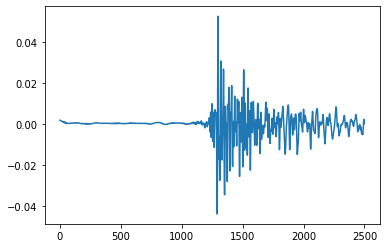

In [ ]:
plt.plot(eta[4,:,1])

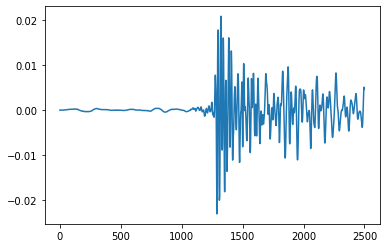

In [ ]:
plt.plot(ag_pred[8,0:2500,0])